In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
import numpy as np
import scipy.io
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

data = scipy.io.loadmat('/content/cylinder_nektar_wake.mat')


U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]


XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T        # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star           # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1


# Setting up the physics Neural network with optimizers, i am testing performance with ADAM and L-BFGS-B.

Hypothesis 0: Adam optimizer might not perform better as they can get stuck at local minima.

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

class PhysicsInformedNN:
    def __init__(self, x, y, t, u, v, layers):
        # Input data
        X = np.concatenate([x, y, t], 1)
        self.lb = X.min(0)
        self.ub = X.max(0)

        self.X = tf.convert_to_tensor(X, dtype=tf.float32)
        self.x = tf.convert_to_tensor(X[:, 0:1], dtype=tf.float32)
        self.y = tf.convert_to_tensor(X[:, 1:2], dtype=tf.float32)
        self.t = tf.convert_to_tensor(X[:, 2:3], dtype=tf.float32)

        self.u = tf.convert_to_tensor(u, dtype=tf.float32)
        self.v = tf.convert_to_tensor(v, dtype=tf.float32)

        # Define neural network using Keras Sequential API
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.InputLayer(shape=(3,)))
        for width in layers[1:-1]:
            self.model.add(tf.keras.layers.Dense(width, activation='tanh',
                                                 kernel_initializer='glorot_normal'))
        self.model.add(tf.keras.layers.Dense(3))  # Output 3 values for u, v, p

        # Define the Adam optimizer
        self.optimizer_Adam = tf.keras.optimizers.Adam()

    # Forward pass through the network
    def neural_net(self, X):
        return self.model(X)

    # Custom loss function with physics constraints
    def compute_loss(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch([self.x, self.y, self.t])
            X_input = tf.concat([self.x, self.y, self.t], 1)
            u_pred, v_pred, p_pred = tf.split(self.neural_net(X_input), 3, axis=1)

            u_x = tape.gradient(u_pred, self.x)
            u_y = tape.gradient(u_pred, self.y)
            u_t = tape.gradient(u_pred, self.t)

            v_x = tape.gradient(v_pred, self.x)
            v_y = tape.gradient(v_pred, self.y)
            v_t = tape.gradient(v_pred, self.t)

            p_x = tape.gradient(p_pred, self.x)
            p_y = tape.gradient(p_pred, self.y)

            f_u = u_t + u_pred * u_x + v_pred * u_y + p_x - 0.01 * (tape.gradient(u_x, self.x) + tape.gradient(u_y, self.y))
            f_v = v_t + u_pred * v_x + v_pred * v_y + p_y - 0.01 * (tape.gradient(v_x, self.x) + tape.gradient(v_y, self.y))

            loss_u = tf.reduce_mean(tf.square(self.u - u_pred))
            loss_v = tf.reduce_mean(tf.square(self.v - v_pred))
            loss_f_u = tf.reduce_mean(tf.square(f_u))
            loss_f_v = tf.reduce_mean(tf.square(f_v))

            loss = loss_u + loss_v + loss_f_u + loss_f_v

        del tape

        return loss

    def train_Adam(self, nIter):
        for epoch in range(nIter):
            with tf.GradientTape() as tape:
                loss_value = self.compute_loss()

            gradients = tape.gradient(loss_value, self.model.trainable_variables)
            self.optimizer_Adam.apply_gradients(zip(gradients, self.model.trainable_variables))

            # Print loss every 100 iterations
            if epoch % 100 == 0:
                print(f"Iteration {epoch}, Loss: {loss_value.numpy()}")

    def train_LBFGS(self):
        func = self.function_factory()

        initial_params = tf.concat([tf.reshape(var, [-1]) for var in self.model.trainable_variables], axis=0)

        results = tfp.optimizer.lbfgs_minimize(
            value_and_gradients_function=func,
            initial_position=initial_params,
            max_iterations=500
        )

        func.assign_new_model_parameters(results.position)

    def predict(self, x_star, y_star, t_star):
        X_star = tf.convert_to_tensor(np.concatenate([x_star, y_star, t_star], 1), dtype=tf.float32)
        u_pred, v_pred, p_pred = tf.split(self.neural_net(X_star), 3, axis=1)
        return u_pred.numpy(), v_pred.numpy(), p_pred.numpy()

    def function_factory(self):
        shapes = [var.shape for var in self.model.trainable_variables]
        n_tensors = len(shapes)

        count = 0
        idx = []  # stitch indices
        part = []  # partition indices

        for shape in shapes:
            n = np.product(shape)
            idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32), shape))
            part.extend([len(idx) - 1] * n)
            count += n

        part = tf.constant(part)

        @tf.function
        def assign_new_model_parameters(params_1d):
            params = tf.dynamic_partition(params_1d, part, n_tensors)
            for i, (shape, param) in enumerate(zip(shapes, params)):
                self.model.trainable_variables[i].assign(tf.reshape(param, shape))

        def func(params_1d):
            assign_new_model_parameters(params_1d)
            with tf.GradientTape() as tape:
                loss_value = self.compute_loss()

            grads = tape.gradient(loss_value, self.model.trainable_variables)
            grads = tf.dynamic_stitch(idx, grads)

            func.iter.assign_add(1)
            tf.print("Iter:", func.iter, "loss:", loss_value)

            return loss_value, grads

        func.iter = tf.Variable(0)
        func.idx = idx
        func.part = part
        func.shapes = shapes
        func.assign_new_model_parameters = assign_new_model_parameters
        return func






In [ ]:
N_train = 5000
layers = [3, 20, 20, 20, 20, 20, 20, 20, 3]  # Corrected to have 3 outputs

idx = np.random.choice(x.shape[0], N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, layers)

model.train_Adam(2000)
model.train_LBFGS()



Iteration 0, Loss: 0.729668378829956
Iteration 100, Loss: 0.15738900005817413
Iteration 200, Loss: 0.15351061522960663
Iteration 300, Loss: 0.12347230315208435
Iteration 400, Loss: 0.10255075246095657
Iteration 500, Loss: 0.09866617619991302
Iteration 600, Loss: 0.09741535037755966
Iteration 700, Loss: 0.09669703990221024
Iteration 800, Loss: 0.09618055075407028
Iteration 900, Loss: 0.09574311226606369
Iteration 1000, Loss: 0.09530022740364075
Iteration 1100, Loss: 0.09471952170133591
Iteration 1200, Loss: 0.093658946454525
Iteration 1300, Loss: 0.09091304242610931
Iteration 1400, Loss: 0.08513923734426498
Iteration 1500, Loss: 0.07988058775663376
Iteration 1600, Loss: 0.07589777559041977
Iteration 1700, Loss: 0.07265531271696091
Iteration 1800, Loss: 0.07032354176044464
Iteration 1900, Loss: 0.06833958625793457


<ipython-input-31-1ead73984876>:87: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  func = self.function_factory()


Iter: 1 loss: 0.0649502799
Iter: 2 loss: 0.0946844071
Iter: 3 loss: 0.0649492368
Iter: 4 loss: 0.0649482
Iter: 5 loss: 0.0649442822
Iter: 6 loss: 0.064930208
Iter: 7 loss: 0.0649984628
Iter: 8 loss: 0.0649253204
Iter: 9 loss: 0.0649004206
Iter: 10 loss: 0.0648989603
Iter: 11 loss: 0.0648802295
Iter: 12 loss: 0.0648649186
Iter: 13 loss: 0.064847894
Iter: 14 loss: 0.0648454949
Iter: 15 loss: 0.0648138076
Iter: 16 loss: 0.0651249
Iter: 17 loss: 0.0648126826
Iter: 18 loss: 0.0647898167
Iter: 19 loss: 0.0647548735
Iter: 20 loss: 0.0647542104
Iter: 21 loss: 0.0647072271
Iter: 22 loss: 0.0647786111
Iter: 23 loss: 0.0646847
Iter: 24 loss: 0.0646275
Iter: 25 loss: 0.0645883232
Iter: 26 loss: 0.0645676255
Iter: 27 loss: 0.0644236
Iter: 28 loss: 0.0642494261
Iter: 29 loss: 0.0642286837
Iter: 30 loss: 0.0639718398
Iter: 31 loss: 0.0671036541
Iter: 32 loss: 0.0639647692
Iter: 33 loss: 0.0638052672
Iter: 34 loss: 0.0642171651
Iter: 35 loss: 0.0637481287
Iter: 36 loss: 0.0635342821
Iter: 37 loss: 0.0

In [ ]:
snap = np.array([100])
x_star = X_star[:, 0:1]
y_star = X_star[:, 1:2]
t_star = np.tile(t[snap], (x_star.shape[0], 1))

# True values at the selected snapshot
u_star = U_star[:, 0, snap]
v_star = U_star[:, 1, snap]
p_star = P_star[:, snap]

# Predicted values from the model
u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)

# Error calculation
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
error_v = np.linalg.norm(v_star - v_pred, 2) / np.linalg.norm(v_star, 2)
error_p = np.linalg.norm(p_star - p_pred, 2) / np.linalg.norm(p_star, 2)

print(f"Relative L2 Error in u: {error_u:.3e}")
print(f"Relative L2 Error in v: {error_v:.3e}")
print(f"Relative L2 Error in p: {error_p:.3e}")


Relative L2 Error in u: 1.258e-01
Relative L2 Error in v: 4.075e-01
Relative L2 Error in p: 1.156e+00


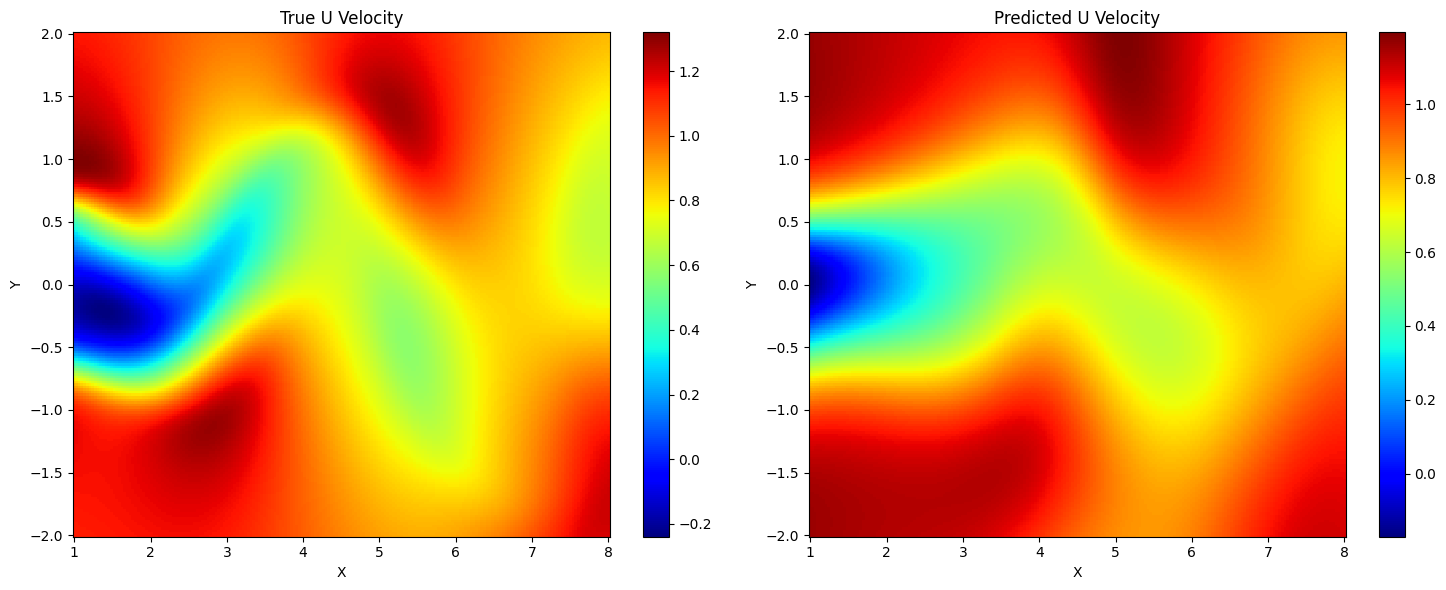

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


lb = X_star.min(0)
ub = X_star.max(0)
nn = 200  # Grid density for interpolation
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x, y)

U_true = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

c1 = axs[0].pcolor(X, Y, U_true, shading='auto', cmap='jet')
fig.colorbar(c1, ax=axs[0])
axs[0].set_title('True U Velocity')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

# Predicted u
c2 = axs[1].pcolor(X, Y, U_pred, shading='auto', cmap='jet')
fig.colorbar(c2, ax=axs[1])
axs[1].set_title('Predicted U Velocity')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()


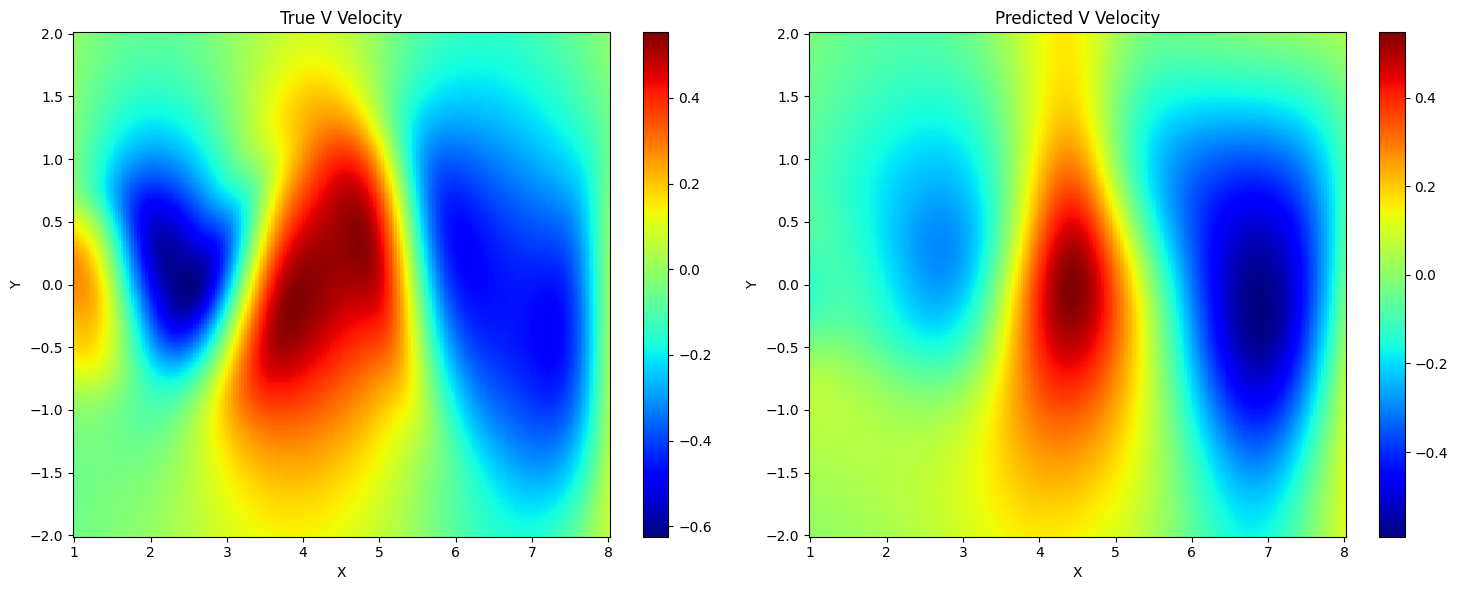

In [ ]:
V_true = griddata(X_star, v_star.flatten(), (X, Y), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')

fig, axs = plt.subplots(1, 2, figsize=(15, 6))


c1 = axs[0].pcolor(X, Y, V_true, shading='auto', cmap='jet')
fig.colorbar(c1, ax=axs[0])
axs[0].set_title('True V Velocity')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

c2 = axs[1].pcolor(X, Y, V_pred, shading='auto', cmap='jet')
fig.colorbar(c2, ax=axs[1])
axs[1].set_title('Predicted V Velocity')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()


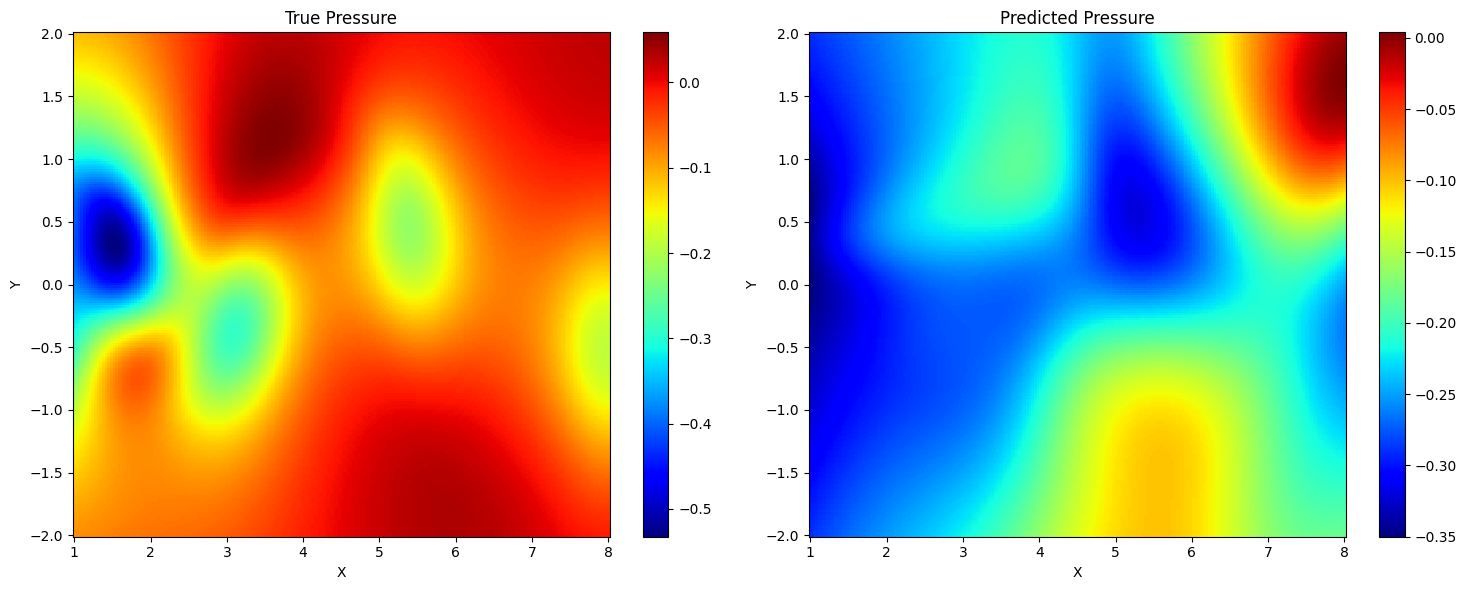

In [ ]:
P_true = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')
P_pred = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

c1 = axs[0].pcolor(X, Y, P_true, shading='auto', cmap='jet')
fig.colorbar(c1, ax=axs[0])
axs[0].set_title('True Pressure')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

c2 = axs[1].pcolor(X, Y, P_pred, shading='auto', cmap='jet')
fig.colorbar(c2, ax=axs[1])
axs[1].set_title('Predicted Pressure')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()


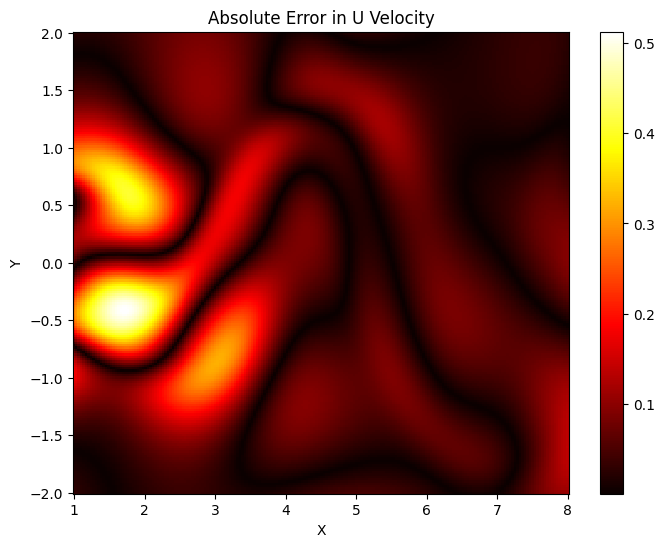

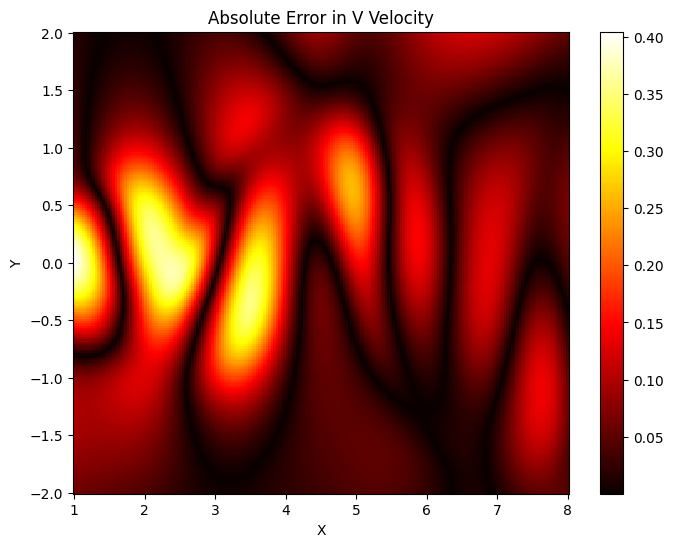

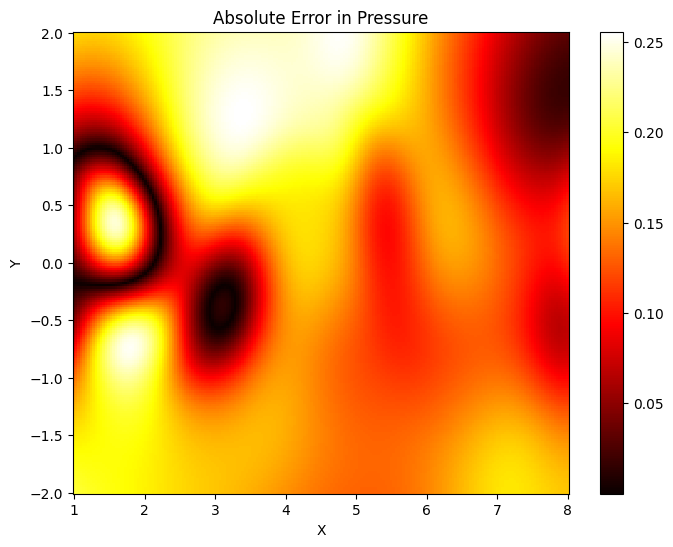

In [ ]:
U_error = np.abs(U_true - U_pred)


plt.figure(figsize=(8, 6))
c = plt.pcolor(X, Y, U_error, shading='auto', cmap='hot')
plt.colorbar(c)
plt.title('Absolute Error in U Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


V_error = np.abs(V_true - V_pred)

plt.figure(figsize=(8, 6))
c = plt.pcolor(X, Y, V_error, shading='auto', cmap='hot')
plt.colorbar(c)
plt.title('Absolute Error in V Velocity')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

P_error = np.abs(P_true - P_pred)

plt.figure(figsize=(8, 6))
c = plt.pcolor(X, Y, P_error, shading='auto', cmap='hot')
plt.colorbar(c)
plt.title('Absolute Error in Pressure')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


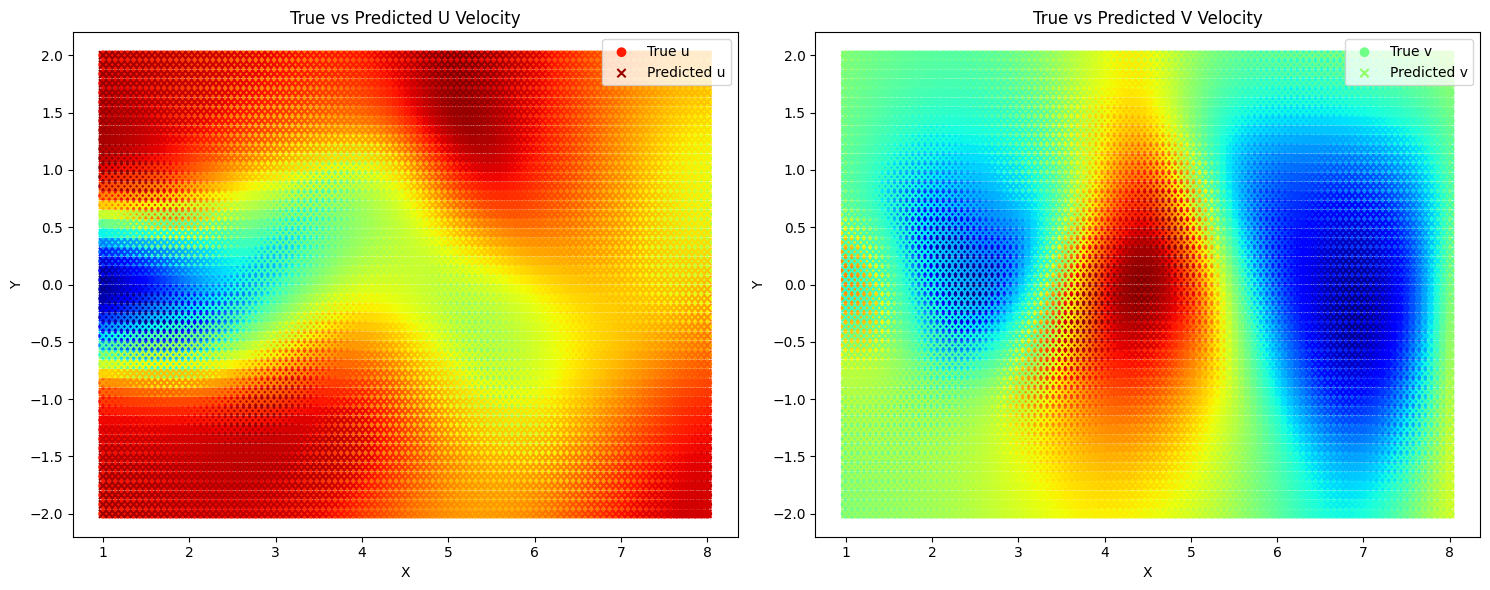

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata

# Frame to be plotted
frame = 100

u_true_frame = U_star[:, 0, frame]
v_true_frame = U_star[:, 1, frame]
p_true_frame = P_star[:, frame]

t_frame = np.tile(t[frame], (x_star.shape[0], 1))
u_pred_frame, v_pred_frame, p_pred_frame = model.predict(x_star, y_star, t_frame)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(X_star[:, 0], X_star[:, 1], c=u_true_frame, cmap='jet', marker='o', label='True u')
axs[0].scatter(X_star[:, 0], X_star[:, 1], c=u_pred_frame.flatten(), cmap='jet', marker='x', label='Predicted u')
axs[0].set_title('True vs Predicted U Velocity')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].legend()

axs[1].scatter(X_star[:, 0], X_star[:, 1], c=v_true_frame, cmap='jet', marker='o', label='True v')
axs[1].scatter(X_star[:, 0], X_star[:, 1], c=v_pred_frame.flatten(), cmap='jet', marker='x', label='Predicted v')
axs[1].set_title('True vs Predicted V Velocity')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].legend()

plt.tight_layout()
plt.show()



In [ ]:
# Check true values for u, v, p at a specific frame
print("True U values for frame:", frame, u_true_frame)
print("True V values for frame:", frame, v_true_frame)
print("True P values for frame:", frame, p_true_frame)

# Check predicted values for u, v, p at a specific frame
print("Predicted U values for frame:", frame, u_pred_frame.flatten())
print("Predicted V values for frame:", frame, v_pred_frame.flatten())
print("Predicted P values for frame:", frame, p_pred_frame.flatten())


True U values for frame: 100 [1.13149962 1.13280141 1.13407282 ... 0.88110477 0.87783768 0.8749812 ]
True V values for frame: 100 [-0.05312507 -0.04967954 -0.0463315  ... -0.03375442 -0.02377922
 -0.01358012]
True P values for frame: 100 [-0.08336564 -0.08253414 -0.08151676 ...  0.02549377  0.02586822
  0.02615973]
Predicted U values for frame: 100 [1.1597884  1.1574271  1.1550984  ... 0.8519157  0.85112864 0.8514768 ]
Predicted V values for frame: 100 [0.00639118 0.00826121 0.01018918 ... 0.02715529 0.03313375 0.03974927]
Predicted P values for frame: 100 [-0.28955525 -0.2864473  -0.2834115  ... -0.00906754 -0.0070219
 -0.00557566]


In [ ]:
U_true = griddata(X_star, u_true_frame.flatten(), (X, Y), method='nearest')
U_pred = griddata(X_star, u_pred_frame.flatten(), (X, Y), method='nearest')

print("Min and Max of Predicted U:", np.min(u_pred_frame), np.max(u_pred_frame))
print("Min and Max of Predicted V:", np.min(v_pred_frame), np.max(v_pred_frame))
print("Min and Max of Predicted P:", np.min(p_pred_frame), np.max(p_pred_frame))


Min and Max of Predicted U: -0.16937414 1.1940997
Min and Max of Predicted V: -0.59046406 0.54653066
Min and Max of Predicted P: -0.3501026 0.0037813187
